# 5장 09. 회귀실습 - 자전거 대여 수요 예측

## 1. bike_train 데이터 살펴보기

: 날짜/시간, 기온 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여횟수가 기재

## 2. 데이터 클렌징 및 가공

### (1) 데이터 살펴보기 

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [18]:
bike_df = pd.read_csv('C:/Users/tb990/Documents/studydata/bike-sharing-demand/bike_train.csv')
print(bike_df.shape)
bike_df.head(3)

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


- (10886, 12): 10886개의 레코드, 12개의 칼럼

In [19]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


- 10886개의 로우데이터 중에 Null값은 없음
- 칼럼 대부분이 int(정수), float(실수)
- 'datatime'칼럼 = object형

년-월-일 시:분:초 -> datatime을 년, 월, 일, 시간로 분리

### (2) 문자열을 시계열 데이터 타입으로 변환 및 추출

In [20]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datatime 타입에서 년, 월 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


- year, month, day, hour 칼럼 추가했으니, datatime 칼럼은 삭제
- count가 있으므로 casual, registered 칼럼 삭제

### (3) 필요없는 칼럼 삭제

In [21]:
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1,inplace=True)

## 2. 다양한 회귀모델에 데이터 세트 적용해 예측성능 측정

### (1) RMSLE, MSE 성능 평가 함수 만들기

- RMSLE: 오류 값의 로그에 대한 RMSE

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
# log 값 변환 시 NaN등의 이슈로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

# 사이킷런의 mean_square_error() 를 이용하여 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE 를 모두 계산 
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)  # MAE 는 사이킷런의 mean_absolute_error() 로 계산
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

- 로그로 변환시 너무 작은 값으로 변환되는 것을 방지 -> log1p(),mean_squared_log_error()

## 3. 로그 변환, 피처 인코딩과 모델 학습/예측/평가

### (1) 선형회귀 객체를 이용해 회귀예측

In [27]:
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LinearRegression , Ridge , Lasso

In [29]:
# count칼럼 y타겟값으로 옮기고, x피처값에서는 삭제하기
y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis = 1,inplace = False)

# 학습데이터/테스트데이터 분할추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3, random_state = 0)

# 선형회귀 학습 및 예측
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test ,pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


- 예측오류로서는 비교적 큰 값

### (2) 실제값과 예측값이 어느 정도 차이가 나는지 오류값이 가장 큰 순으로 확인 

In [31]:
# DataFrame에 컬럼으로 실제 대여 횟수(count)와 예측값을 서로 비교 할 수 있도록 생성
def get_top_error_data(y_test, pred, n_tops = 5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count']) #실제 대여 횟수
    result_df['predicted_count']= np.round(pred) # 예측값
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count']) # 실제 대여횟수 - 예측값
   
    print(result_df.sort_values('diff', ascending=False)[:n_tops]) # 예측값과 실제값이 가장 큰 데이터 순으로 출력
    
get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


- 예측 오류가 꽤 큼 -> Target 값의 분포가 왜곡된 형태인가..? 확인

### (3) 결괏값이 정규분포로 되어 있는 지 확인

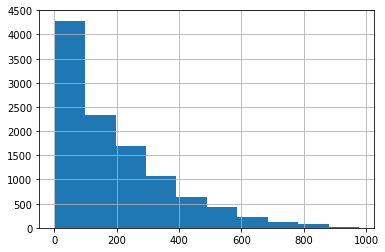

In [32]:
y_target.hist()

- count() 칼럼 값이 정규분포가 아닌 0-20에 몰려있는 왜곡된 분포 -> 로그변환으로 정규분포형태로 바꾸자!

### (4) 로그변환으로 왜곡된 분포를 정규분포로 변환하기

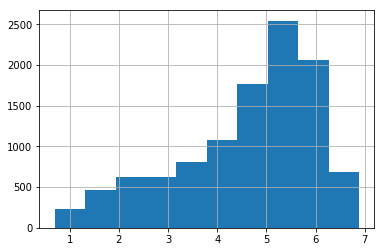

In [33]:
# log1p() 적용
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

- 왜곡된 정도가 많이 향상됨!

### (5) 다시 학습한 후 평가수행 후, expm1으로 원상태 복귀

In [34]:
# 타겟 컬럼인 count값을 log1p로 로그 변환(앞에서 했던거임)
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)
lr_reg = LinearRegression() # 모델
lr_reg.fit(X_train, y_train) # 학습
pred = lr_reg.predict(X_test) # 예측

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 로그 변환된 타겟 기반으로 학습되어 예측되었으므로 다시 exmp1으로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp ,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


결과: RMSLE오류는 줄었지만, RMSE는 증가
* 로그변환 적용 전  -  RMSLE: 1.165, RMSE: 140.900, MAE: 105.924
* 로그변환 적용 후  -  RMSLE: 1.017, RMSE: 162.594, MAE: 109.286




-> 이유가 뭐지? 각 피처의 회귀계수 값 시각화를 해보자!

### (6) 각 피처의 회귀계수 값 시각화

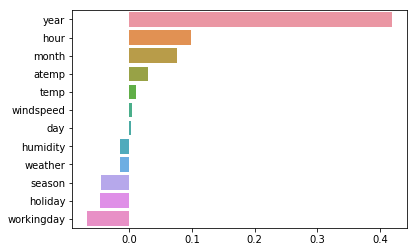

In [37]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending = False)
sns.barplot(x = coef_sort.values, y = coef_sort.index)

* year 피처의 회귀계수 값이 독보적으로 큰 값을 가지고 있음 -> 2011, 2012년으로만 이뤄져있음..상관관계 있다고 하기 어려움

결론: 카테고리형 피처인데 사이킷런은 숫자형으로만 지원하기 때문에 영향도가 크게 나옴

-> 선형회귀에서는 피처 인코딩에 원-핫 인코딩을 적용해 변환해야 한다!

### (7) get_dummies()를 이용해 모두 원-핫 인코딩 적용하기

In [39]:
# 'year', month', 'day', 'hour'등의 피처를 One-Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday','season','weather'])

### (8) 다시 예측성능 확인

In [40]:
# 원-핫 인코딩이 적용된 피처데이터 세트 기반으로 학습/예측 데이터 분할. 
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train) 
    pred = model.predict(X_test) # 예측
    if is_expm1 :
        y_test = np.expm1(y_test) # 로그변환 값 원래값으로 복귀
        pred = np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict    

# 선형회귀, 릿지, 라소 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


결과: 원핫 인코딩을 적용 후 선형회귀 예측성능이 많이 향상됨.
* 로그변환 적용 전  -  RMSLE: 1.165, RMSE: 140.900, MAE: 105.924
* 로그변환 적용 후  -  RMSLE: 1.017, RMSE: 162.594, MAE: 109.286
* 원핫인코딩, 로그변환 적용후 - RMSLE: 0.590, RMSE: 97.688, MAE: 63.382

### (9) 다시 각 피처의 회귀계수 값 시각화

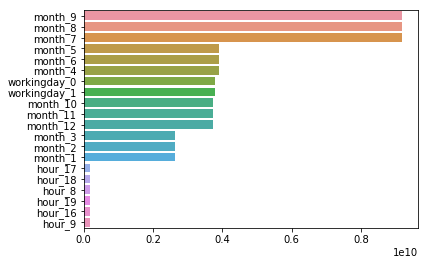

In [42]:
coef = pd.Series(lr_reg.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20] # 크기 순으로
sns.barplot(x=coef_sort.values, y=coef_sort.index)

회귀계수가 높은 피처들
* 월 관련 피처: month_9, month_8, month_7
* workingday 관련 피처
* hour 관련 피처들

결론: 월, 주말/주중, 시간대 관련 피처의 회귀계수가 높아짐 -> 이전은 연도 회귀계수가 높았었음.

## 4. 회귀트리를 이용한 회귀예측

In [43]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [44]:
# 랜덤 포레스트, GBM, XGBoost, LightGBM 모델 별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

# XGBoost의 경우 DataFrame이 입력 될 경우 버전에 따라 오류 발생 가능. ndarray로 변환.
for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354, RMSE: 50.358, MAE: 31.196
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.345, MAE: 32.745
[18:26:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSLE: 0.345, RMSE: 58.245, MAE: 35.768
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


결론: 앞의 선형회귀모델보다 예측성능이 개선. But, 회귀트리가 선형회귀보다 더 나은 성능을 가진다는 의미 아님 

* 로그변환 적용 전  -  RMSLE: 1.165, RMSE: 140.900, MAE: 105.924
* 로그변환 적용 후  -  RMSLE: 1.017, RMSE: 162.594, MAE: 109.286
* 원핫인코딩, 로그변환 적용후 - RMSLE: 0.590, RMSE: 97.688, MAE: 63.382